In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('personality_dataset.csv')
df.head(10)

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert
5,1.0,No,7.0,5.0,No,6.0,6.0,Extrovert
6,4.0,No,9.0,NaN,No,7.0,7.0,Extrovert
7,2.0,No,8.0,4.0,No,7.0,8.0,Extrovert
8,10.0,Yes,1.0,3.0,Yes,0.0,3.0,Introvert
9,0.0,No,8.0,6.0,No,13.0,8.0,Extrovert


## Checking Null values

In [3]:
df.isnull().sum()

Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64

### Ordinal:
    - Time_spent_Alone: Hours spent alone daily (0–11).
    - Social_event_attendance: Frequency of social events (0–10).
    - Going_outside: Frequency of going outside (0–7).
    - Friends_circle_size: Number of close friends (0–15).
    - Post_frequency: Social media post frequency (0–10).
### Nominal:
    - Stage_fear: Presence of stage fright (Yes/No).
    - Drained_after_socializing: Feeling drained after socializing (Yes/No).
### Label:
    - Personality: Target variable (Extrovert/Introvert).*


In [4]:
print(df.columns)
ordinal_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',  'Friends_circle_size', 'Post_frequency']
nominal_cols = ['Stage_fear', 'Drained_after_socializing']

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')


### Impute the value for missing data.
### Ordinal: mean or median, choice of mean and median depends on skewness test. Plus or minus 1 skew means impute by median , else mean
### Nominal: mode. 
### Also filling these values based on label to avoid outliers.

In [5]:
def groupwise_smart_impute(df, cols, group_col, skew_thresh=1.0, ordinal=True):
    for col in cols:
        if df[col].isnull().sum() == 0:
            continue  # Skip if no missing values

        print(f"\n--- Processing column: {col} ---")

        if ordinal:
            for group, group_df in df.groupby(group_col):
                group_index = group_df.index
                group_values = group_df[col]

                if group_values.isnull().sum() == 0:
                    continue  # Nothing to fill in this group

                skew = group_values.skew()
                print(f"Skew for '{col}' in group '{group}': {skew:.2f}")

                if abs(skew) < skew_thresh:
                    fill_value = group_values.mean()
                    method = 'mean'
                else:
                    fill_value = group_values.median()
                    method = 'median'

                df.loc[group_index, col] = df.loc[group_index, col].fillna(fill_value)
                print(f"Group '{group}': filled with {method} = {fill_value:.2f}")

        else:
            # For non-ordinal (categorical), use group-wise mode
            def mode_or_nan(series):
                mode_val = series.mode()
                return mode_val.iloc[0] if not mode_val.empty else np.nan

            df[col] = df.groupby(group_col)[col].transform(
                lambda x: x.fillna(mode_or_nan(x))
            )
            print(f"Filled '{col}' with mode by group '{group_col}'")

    return df


In [6]:
df = groupwise_smart_impute(df, ordinal_cols, group_col='Personality')



--- Processing column: Time_spent_Alone ---
Skew for 'Time_spent_Alone' in group 'Extrovert': 2.13
Group 'Extrovert': filled with median = 2.00
Skew for 'Time_spent_Alone' in group 'Introvert': -0.43
Group 'Introvert': filled with mean = 7.08

--- Processing column: Social_event_attendance ---
Skew for 'Social_event_attendance' in group 'Extrovert': -0.49
Group 'Extrovert': filled with mean = 6.02
Skew for 'Social_event_attendance' in group 'Introvert': 1.78
Group 'Introvert': filled with median = 2.00

--- Processing column: Going_outside ---
Skew for 'Going_outside' in group 'Extrovert': -0.75
Group 'Extrovert': filled with mean = 4.63
Skew for 'Going_outside' in group 'Introvert': 1.88
Group 'Introvert': filled with median = 1.00

--- Processing column: Friends_circle_size ---
Skew for 'Friends_circle_size' in group 'Extrovert': -0.31
Group 'Extrovert': filled with mean = 9.17
Skew for 'Friends_circle_size' in group 'Introvert': 1.99
Group 'Introvert': filled with median = 3.00

--

In [7]:
df = groupwise_smart_impute(df, nominal_cols, group_col='Personality', ordinal=False)


--- Processing column: Stage_fear ---
Filled 'Stage_fear' with mode by group 'Personality'

--- Processing column: Drained_after_socializing ---
Filled 'Drained_after_socializing' with mode by group 'Personality'


In [8]:
df.isna().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [9]:
### Outlier detection using boxplot

In [10]:
# Select numeric columns excluding labels
label_cols = ['Personality']
numeric_cols = df.select_dtypes(include='number').columns.difference(label_cols)

# Melt the DataFrame to long format
df_melted = df[numeric_cols].melt(var_name='Feature', value_name='Value')

# Create interactive boxplot
fig = px.box(df_melted, x='Feature', y='Value', points='outliers', title="Interactive Boxplots")
fig.update_layout(xaxis_title="Feature", yaxis_title="Value")
fig.show()

### One-Hot Encoding for categorical features

In [11]:
from sklearn.preprocessing import LabelEncoder
df = pd.get_dummies(df, columns=nominal_cols + ['Personality'], drop_first=True)
for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

### To find correlation

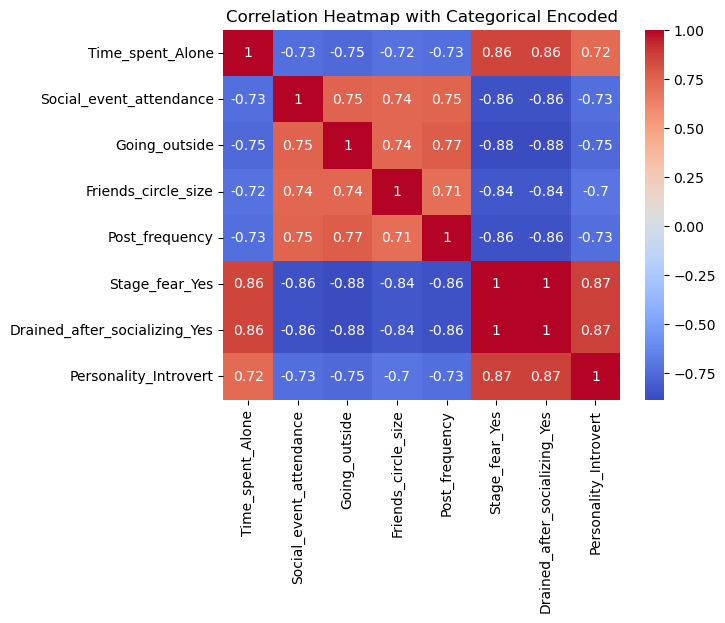

In [12]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap with Categorical Encoded")
plt.show()

### Data Preprocessing steps:
### Scaling using Standard Scaler
### Splitting: Train data: 70%, Test data: 30%
### Stratified splitting to keep targets proportionally 

### Target labels looks balanced, which is a good sign for classification task

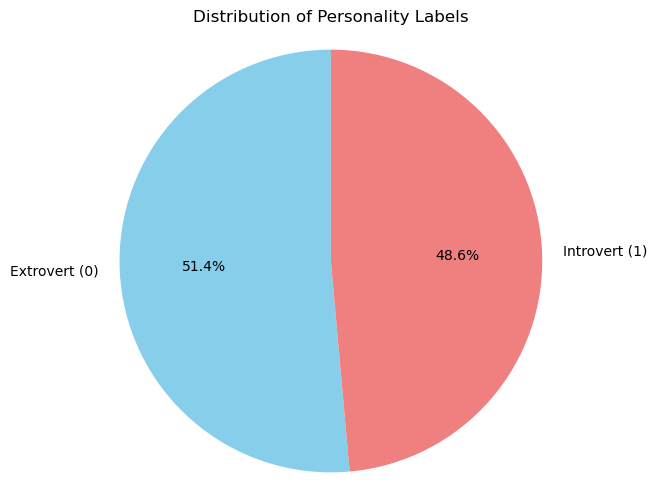

In [16]:
import matplotlib.pyplot as plt

# Count each class
label_counts = y.value_counts()
labels = ['Extrovert (0)', 'Introvert (1)']
sizes = [label_counts[0], label_counts[1]]

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title("Distribution of Personality Labels")
plt.axis('equal')  # Ensures pie is a circle
plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
# Separate features (X) and target label (y)
X = df.drop(columns=['Personality_Introvert'])
y = df['Personality_Introvert']

# Step 1: Train-test split (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Step 2: Feature scaling (only numeric columns)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Training
## Logistic Regression

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Define base model
log_model = LogisticRegression(max_iter=1000, random_state=42)

# 2. Define hyperparameter grid
log_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

# 3. Run GridSearchCV
log_grid = GridSearchCV(log_model, log_param_grid, cv=5, scoring='f1', n_jobs=-1)
log_grid.fit(X_train_scaled, y_train)

# 4. Best model
best_log_model = log_grid.best_estimator_

# 5. Predictions and Evaluation
y_pred_log = best_log_model.predict(X_test_scaled)

print("Best Logistic Regression Parameters:", log_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))


Best Logistic Regression Parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       447
           1       0.90      0.94      0.92       423

    accuracy                           0.92       870
   macro avg       0.92      0.92      0.92       870
weighted avg       0.92      0.92      0.92       870

Accuracy: 0.9195402298850575


## KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score


In [19]:
knn_model = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


In [20]:
knn_grid = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)

best_knn_model = knn_grid.best_estimator_

In [21]:
y_pred_knn = best_knn_model.predict(X_test_scaled)

print("Best KNN Parameters:", knn_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       447
           1       0.90      0.94      0.92       423

    accuracy                           0.92       870
   macro avg       0.92      0.92      0.92       870
weighted avg       0.92      0.92      0.92       870

Accuracy: 0.9183908045977012


## SVC

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [23]:
svc_model = SVC(probability=True)

svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

svc_grid = GridSearchCV(svc_model, svc_param_grid, cv=5, scoring='f1', n_jobs=-1)
svc_grid.fit(X_train_scaled, y_train)

best_svc_model = svc_grid.best_estimator_


In [24]:
y_pred_svc = best_svc_model.predict(X_test_scaled)

print("Best SVC Parameters:", svc_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_svc))
print("Accuracy:", accuracy_score(y_test, y_pred_svc))


Best SVC Parameters: {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       447
           1       0.90      0.94      0.92       423

    accuracy                           0.92       870
   macro avg       0.92      0.92      0.92       870
weighted avg       0.92      0.92      0.92       870

Accuracy: 0.9195402298850575


## RandomForest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [28]:
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}


In [29]:
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

best_rf_model = rf_grid.best_estimator_


In [30]:
y_pred_rf = best_rf_model.predict(X_test_scaled)

print("Best Random Forest Parameters:", rf_grid.best_params_)
print("\Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Best Random Forest Parameters: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
\Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       447
           1       0.90      0.93      0.92       423

    accuracy                           0.92       870
   macro avg       0.92      0.92      0.92       870
weighted avg       0.92      0.92      0.92       870

Accuracy: 0.9172413793103448


### Model Comparison

In [32]:
import plotly.express as px
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you already have predictions:
# y_pred_log, y_pred_knn, y_pred_svc, y_pred_rf
# and y_test

metrics = {
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_log),
        "Precision": precision_score(y_test, y_pred_log),
        "Recall": recall_score(y_test, y_pred_log),
        "F1-score": f1_score(y_test, y_pred_log)
    },
    "KNN": {
        "Accuracy": accuracy_score(y_test, y_pred_knn),
        "Precision": precision_score(y_test, y_pred_knn),
        "Recall": recall_score(y_test, y_pred_knn),
        "F1-score": f1_score(y_test, y_pred_knn)
    },
    "SVC": {
        "Accuracy": accuracy_score(y_test, y_pred_svc),
        "Precision": precision_score(y_test, y_pred_svc),
        "Recall": recall_score(y_test, y_pred_svc),
        "F1-score": f1_score(y_test, y_pred_svc)
    },
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1-score": f1_score(y_test, y_pred_rf)
    }
}

# Convert to long format for Plotly
results_df = pd.DataFrame(metrics).T.reset_index().rename(columns={'index': 'Model'})
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot interactive bar chart
fig = px.bar(
    results_melted,
    x='Model',
    y='Score',
    color='Metric',
    barmode='group',
    title='Model Comparison Across Evaluation Metrics (Interactive)',
    height=500
)
fig.update_layout(
    yaxis=dict(range=[0, 1]),
    legend_title_text='Metric'
)
fig.show()
